## Loading data

In [ ]:
!pip install mlxtend
!pip install rfpimp

In [ ]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import classification_report, confusion_matrix  
import warnings
warnings.filterwarnings('ignore')
from rfpimp import *
import random
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
random.seed(1234)

In [ ]:
import os
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/Shareddrives/DSO 530 Project")

In [ ]:
data_primary = pd.read_csv("./option_train.csv")

In [ ]:
data_primary

* Value (C):	Current	option	value
* S:	Current	asset	value
* K:	Strike	price	of	option
* r:	Annual	interest	rate
* tau:	Time	to	maturity	(in	years)
* BS:	The	Black-Scholes	 formula	was applied	to	this	data	(using some �) to	get	C_pred. and	If	an	option has	C_pred	– C	>	0,	i.e.,	the	prediction over	estimated	the	option	value, we	associate	that	option by (Over);	otherwise, we	associate	that	option with	(Under).

# Missing data

In [ ]:
data_primary.describe()

,Value,S,K,tau,r
count,1679.000000,1679.000000,1678.000000,1679.000000,1680.000000
mean,15.072013,440.639445,438.241955,0.437519,0.030235
std,14.036492,13.130436,23.408989,7.057555,0.000557
min,0.125000,0.000000,375.000000,0.003968,0.029510
25%,2.255002,433.863864,420.000000,0.119048,0.029820
50%,11.220588,442.525366,440.000000,0.202381,0.030130
75%,25.745904,447.320414,455.000000,0.285714,0.030540
max,60.149367,455.880619,500.000000,250.000000,0.031880


## Null Values

In [ ]:
data_primary.isnull().sum()

Value    1
S        1
K        2
tau      1
r        0
BS       0
dtype: int64

In [ ]:
#Drop all records with atleast one NULL value
data_primary.dropna(inplace=True)

In [ ]:
data_primary.shape

(1678, 6)

## Outliers

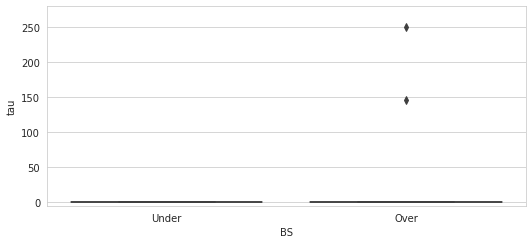

In [ ]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
sns.set_style("whitegrid")

ax = sns.boxplot(x="BS", y="tau", data=data_primary)
plt.ylim(-5, 280)
plt.show()

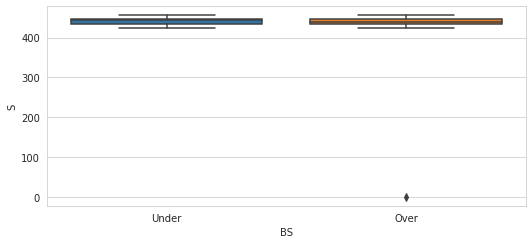

In [ ]:
#S Distribution to detect outliers

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
sns.set_style("whitegrid")


ax = sns.boxplot(x="BS", y="S", data=data_primary)
plt.show()

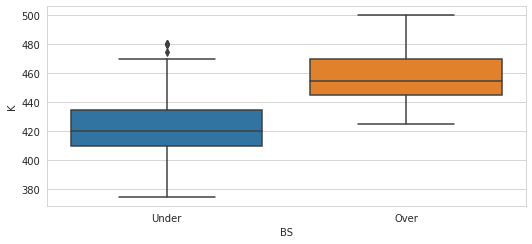

In [ ]:
#K Distribution to detect outliers

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
sns.set_style("whitegrid")


ax = sns.boxplot(x="BS", y="K", data=data_primary)
plt.show()


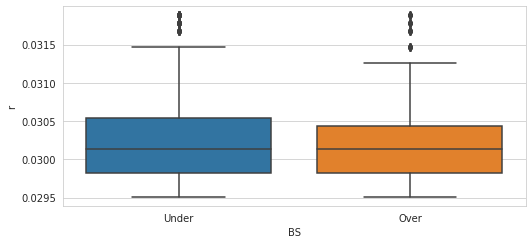

In [ ]:
#r Distribution to detect outliers

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
sns.set_style("whitegrid")


ax = sns.boxplot(x="BS", y="r", data=data_primary)
plt.show()

In [ ]:
# removing records with Tau and S outlier values
data_primary = data_primary[data_primary.S > 0]
data_primary = data_primary[data_primary.tau < 50]

In [ ]:
data_primary.shape

(1675, 6)

# EDA

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45b1c2ad50>]],
      dtype=object)

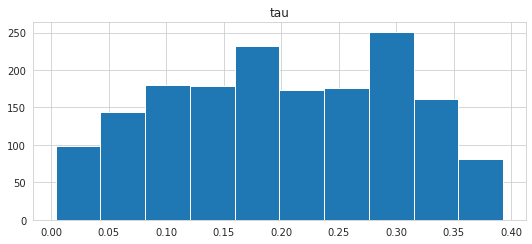

In [ ]:
data_primary.hist("tau")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45b1b49b90>]],
      dtype=object)

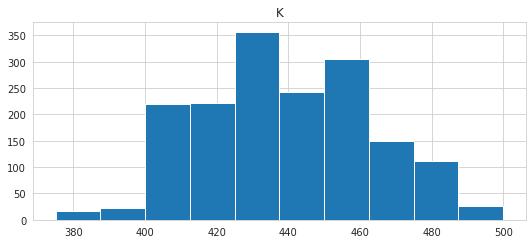

In [ ]:
data_primary.hist("K")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45b1b237d0>]],
      dtype=object)

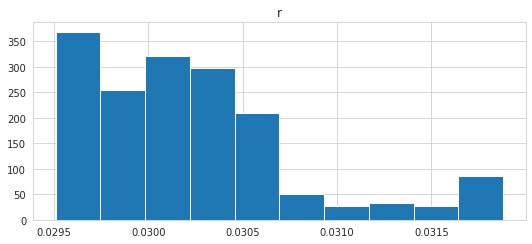

In [ ]:
data_primary.hist("r")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45b1a5ea10>]],
      dtype=object)

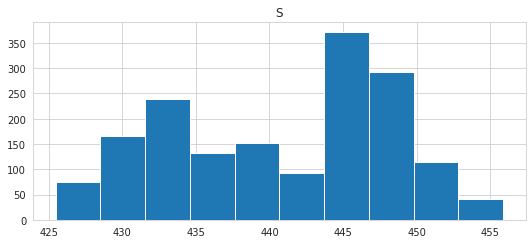

In [ ]:
data_primary.hist("S")

# Feature Engineering

In [ ]:
data_primary["BS_flag"] = [0 if i == "Under" else 1 for i in data_primary.BS]

In [ ]:
# Domain Knowledge Expertise
data_primary["S/K"] = data_primary.S/data_primary.K #Currentassetvalue/Strikepriceofoption
data_primary["S-K_abs"] = abs(data_primary.S - data_primary.K) # abs(Currentassetvalue - Strikepriceofoption)
data_primary["tau_underroot"] = [math.sqrt(i) for i in data_primary.tau] #sqrt of Timetomaturity
data_primary["tau_power2"] = pow(data_primary.tau,2) # Timetomaturity in power 2
data_primary["tau_power4"] = pow(data_primary.tau,4) # Timetomaturity in power 4
data_primary["1+r"] = 1 + data_primary.r # 1 + Annualinterestrate

In [ ]:
for col_name in ['Value', 'S', 'K', 'tau', 'r', 'BS_flag', 'S/K', 'S-K_abs','tau_underroot', 'tau_power2', 'tau_power4', '1+r']:
    data_primary[col_name] = pd.to_numeric(data_primary[col_name])

In [ ]:
data_primary.columns

Index(['Value', 'S', 'K', 'tau', 'r', 'BS', 'BS_flag', 'S/K', 'S-K_abs',
       'tau_underroot', 'tau_power2', 'tau_power4', '1+r'],
      dtype='object')

# Data Preparation and Test Train Split

In [ ]:
data_primary.reset_index(drop=True, inplace= True)

In [ ]:
data_primary2 = data_primary.loc[:,[ 'S', 'K', 'tau', 'r', 'S/K', 'S-K_abs', 'tau_underroot','tau_power2', 'tau_power4', '1+r']]

scaler = MinMaxScaler()
scaler.fit(data_primary2)
data_primary2 = pd.DataFrame(scaler.transform(data_primary2), columns = ['S', 'K', 'tau', 'r', 'S/K', 'S-K_abs', 'tau_underroot','tau_power2', 'tau_power4', '1+r'])

for i in ['S', 'K', 'tau', 'r', 'S/K', 'S-K_abs', 'tau_underroot','tau_power2', 'tau_power4', '1+r']:
    data_primary[i] = data_primary2[i]

data_primary

,Value,S,K,tau,r,BS,BS_flag,S/K,S-K_abs,tau_underroot,tau_power2,tau_power4,1+r
0,21.670404,0.202299,0.36,0.867347,0.261603,Under,0,0.527326,0.207005,0.924440,0.754592,0.569447,0.261603
1,0.125000,0.050749,0.72,0.418367,0.738397,Over,1,0.102610,0.677849,0.612382,0.179898,0.032393,0.738397
2,20.691244,0.075309,0.32,0.673469,0.696203,Under,0,0.539275,0.227339,0.802844,0.457959,0.209777,0.696203
3,1.035002,0.862901,0.68,0.153061,0.088608,Over,1,0.349871,0.147426,0.335200,0.026020,0.000682,0.088608
4,39.553020,0.698712,0.28,0.418367,0.046414,Under,0,0.767650,0.655245,0.612382,0.179898,0.032393,0.046414
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,1.470000,0.622358,0.80,0.693878,0.350211,Over,1,0.169640,0.546000,0.816394,0.485714,0.235969,0.350211
1671,34.927317,0.426906,0.28,0.765306,0.088608,Under,0,0.689362,0.507615,0.862336,0.589286,0.347307,0.088608
1672,41.127997,0.084513,0.12,0.428571,1.000000,Under,0,0.798663,0.678880,0.620952,0.188571,0.035590,1.000000
1673,0.440003,0.447538,0.84,0.744898,0.046414,Over,1,0.088783,0.730260,0.849434,0.558673,0.312166,0.046414


In [ ]:
X = data_primary.loc[:,['S', 'K', 'tau', 'r', 'S/K', 'S-K_abs','tau_underroot', 'tau_power2', 'tau_power4', '1+r']]
y2 = data_primary.loc[:,['BS_flag']]
y1 = data_primary.loc[:,['Value']]

X_train, X_test, y_train2, y_test2 =train_test_split(X, y2, test_size=0.3, random_state=0, stratify=y2)

y_train1 = pd.DataFrame(columns = ['Value'])
y_test1 = pd.DataFrame(columns = ['Value'])

for i in y_train2.index:
    y_train1.loc[i,'Value'] = data_primary.loc[i,'Value']

for i in y_test2.index:
    y_test1.loc[i,'Value'] = data_primary.loc[i,'Value']

# Value Prediction

## Linear Regression

### Feature selection

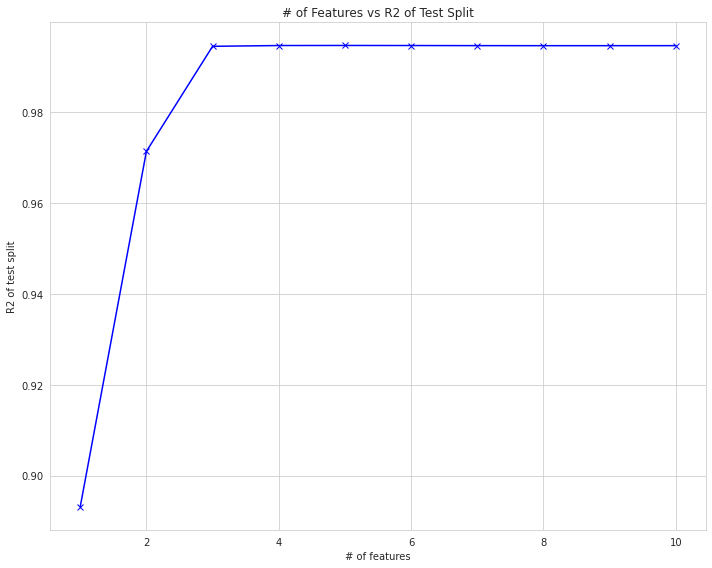

In [ ]:
feature_count = list(range(1,11))
R2 = []

for k in feature_count:
  Linear_reg = LinearRegression()
  sfs1 = sfs(Linear_reg,k_features=k, forward=True, scoring='r2')
  sfs1.fit(X_train, y_train1)
  feat_names = list(sfs1.k_feature_names_)
  model = LinearRegression().fit(X_train[feat_names], y_train1)
  r_sq = model.score(X_test[feat_names], y_test1) 
  R2.append(r_sq)

plt.figure(figsize=(10,8))
plt.plot(feature_count, R2, 'bx-')
plt.xlabel('# of features')
plt.ylabel('R2 of test split')
plt.title('# of Features vs R2 of Test Split')
plt.show()

In [ ]:
Linear_reg = LinearRegression()
sfs1 = sfs(Linear_reg,k_features=3, forward=True, scoring='r2')
sfs1.fit(X_train, y_train1)
feat_names_LinR = list(sfs1.k_feature_names_)
print(feat_names_LinR)

['tau', 'S/K', 'S-K_abs']


In [ ]:
feat_names_LinR = feat_names_LinR + ['r']

### Data Modeling

In [ ]:
# doing K-Fold validation to check model performance
cv = KFold(n_splits=5, random_state=1234, shuffle=True)
regression_model = LinearRegression()
regression_model.fit(X_train[feat_names_LinR], y_train1)
model_score = cross_val_score(regression_model, X_train[feat_names_LinR], y_train1, cv=cv, scoring = 'r2')

print("Linear Regression: ")
print("R squared of 5-folds:",model_score,"\n(mean R squared:",np.mean(model_score),")")


Linear Regression: 
R squared of 5-folds: [0.99574382 0.9945653  0.9947298  0.99404035 0.99517379] 
(mean R squared: 0.9948506115337015 )


In [ ]:
regression_model.coef_

array([[ 9.0445633 , 64.44681028, 15.2009513 ,  0.1755355 ]])

### Model Performance on Test Set (User created)

In [ ]:
#Checking Model Performance on Test Set

r_sq = regression_model.score(X_test[feat_names_LinR], y_test1) 
r_sq

0.9945275988505234

## Random Forest Regressor

### Feature Selection

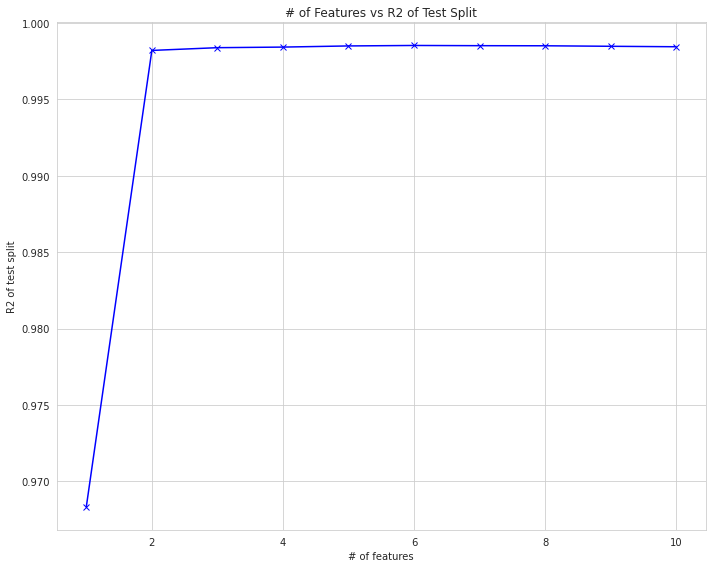

In [ ]:
feature_count = list(range(1,11))
R2 = []

for k in feature_count:
  rf_reg = RandomForestRegressor(random_state=1234)
  sfs2 = sfs(rf_reg,k_features=k, forward=True, scoring='r2')
  sfs2.fit(X_train, y_train1)
  feat_names = list(sfs2.k_feature_names_)
  model = RandomForestRegressor(random_state=1234).fit(X_train[feat_names], y_train1)
  r_sq = model.score(X_test[feat_names], y_test1) 
  R2.append(r_sq)

plt.figure(figsize=(10,8))
plt.plot(feature_count, R2, 'bx-')
plt.xlabel('# of features')
plt.ylabel('R2 of test split')
plt.title('# of Features vs R2 of Test Split')
plt.show()

In [ ]:
rf_reg = RandomForestRegressor(random_state=1234)
sfs2 = sfs(rf_reg,k_features=2, forward=True, scoring='r2')
sfs2.fit(X_train, y_train1)
feat_names_rfR = list(sfs2.k_feature_names_)
print(feat_names_rfR)

['S/K', 'tau_underroot']


In [ ]:
feat_names_rfR = feat_names_rfR + ['r']

### Data Modeling

In [ ]:
cv = KFold(n_splits=5, random_state=1234, shuffle=True)
rf_reg = RandomForestRegressor(random_state=1234)
rf_reg.fit(X_train[feat_names_rfR], y_train1)
model_score = cross_val_score(rf_reg, X_train[feat_names_rfR], y_train1, cv=cv, scoring = 'r2')

print("RF Regression: ")
print("R squared of 5-folds:",model_score,"\n(mean R squared:",np.mean(model_score),")")

r_sq = rf_reg.score(X_test[feat_names_rfR], y_test1) 
print("RF Regression R2 on test dataset: ", r_sq)

RF Regression: 
R squared of 5-folds: [0.99772576 0.99752309 0.99746519 0.99791723 0.99740396] 
(mean R squared: 0.9976070480078164 )
RF Regression R2 on test dataset:  0.998211544820166


### Hyperparameter Tuning

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 20)]
# max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
max_depth.append(None)
min_samples_split = [2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

grid_RF_reg = RandomizedSearchCV(RandomForestRegressor(random_state=1234),random_grid, cv=5, scoring = 'r2',random_state = 1234)
grid_RF_reg.fit(X_train[feat_names_rfR],y_train2)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1234),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, None],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [100, 105, 110, 115,
                                                         121, 126, 131, 136,
                                                         142, 147, 152, 157,
                                                         163, 168, 173, 178,
                                                         184, 189, 194, 200]},
                   random_state=1234, scoring='r2')

In [ ]:
print(grid_RF_reg.best_params_)

{'n_estimators': 194, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 5, 'bootstrap': True}


In [ ]:
cv = KFold(n_splits=5, random_state=1234, shuffle=True)
rf_reg2 = RandomForestRegressor(n_estimators = 194, min_samples_split =  3, min_samples_leaf = 1, max_depth = 5, bootstrap= True, random_state=1234)
rf_reg2.fit(X_train[feat_names_rfR], y_train1)
model_score = cross_val_score(rf_reg2, X_train[feat_names_rfR], y_train1, cv=cv, scoring = 'r2')

print("RF Regression: ")
print("R squared of 5-folds:",model_score,"\n(mean R squared:",np.mean(model_score),")")

r_sq2 = rf_reg2.score(X_test[feat_names_rfR], y_test1) 
print("RF Regression R2 on test dataset: ", r_sq2)

RF Regression: 
R squared of 5-folds: [0.99279578 0.99242773 0.9935035  0.99371717 0.99439174] 
(mean R squared: 0.9933671838969798 )
RF Regression R2 on test dataset:  0.994440353117182


# BS Prediction

## Logistic regression

### Feature selection

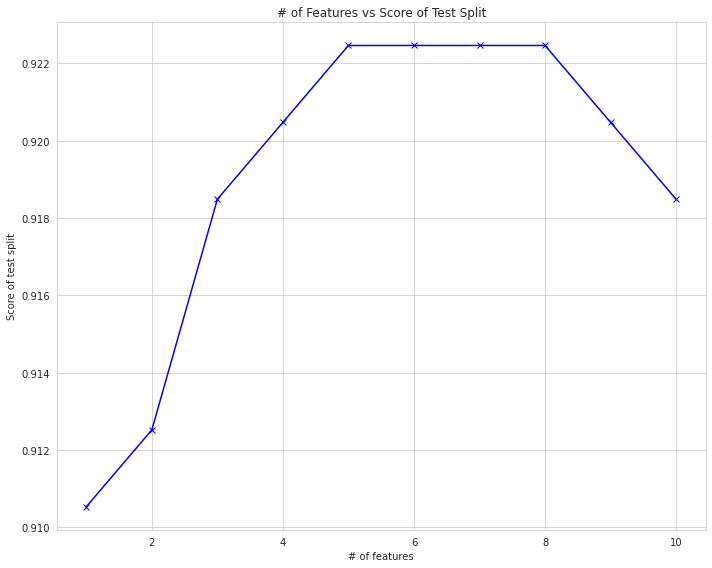

In [ ]:
feature_count = list(range(1,11))
score_list = []

for k in feature_count:
  Logistic_reg = LogisticRegression(random_state= 1234)
  sfs3 = sfs(Logistic_reg,k_features=k, forward=True, scoring='roc_auc')
  sfs3.fit(X_train, y_train2)
  feat_names = list(sfs3.k_feature_names_)
  model = LogisticRegression(random_state= 1234).fit(X_train[feat_names], y_train2)
  score = model.score(X_test[feat_names], y_test2) 
  score_list.append(score)

plt.figure(figsize=(10,8))
plt.plot(feature_count, score_list, 'bx-')
plt.xlabel('# of features')
plt.ylabel('Score of test split')
plt.title('# of Features vs Score of Test Split')
plt.show()

In [ ]:
Logistic_reg = LogisticRegression(random_state= 1234)
sfs3 = sfs(Logistic_reg,k_features=5, forward=True, scoring='roc_auc')
sfs3.fit(X_train, y_train2)
feat_names_LogR = list(sfs3.k_feature_names_)
print(feat_names_LogR)

['S', 'r', 'S/K', 'tau_power2', 'tau_power4']


In [ ]:
Logistic_reg = LogisticRegression(random_state= 1234)
Logistic_reg.fit(X_train[feat_names_LogR], y_train2)
predictions_Log = Logistic_reg.predict(X_test[feat_names_LogR])
print(confusion_matrix(y_test2,predictions_Log))
print(classification_report(y_test2,predictions_Log))

[[264  20]
 [ 19 200]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       284
           1       0.91      0.91      0.91       219

    accuracy                           0.92       503
   macro avg       0.92      0.92      0.92       503
weighted avg       0.92      0.92      0.92       503



## SVM

### Feature selection

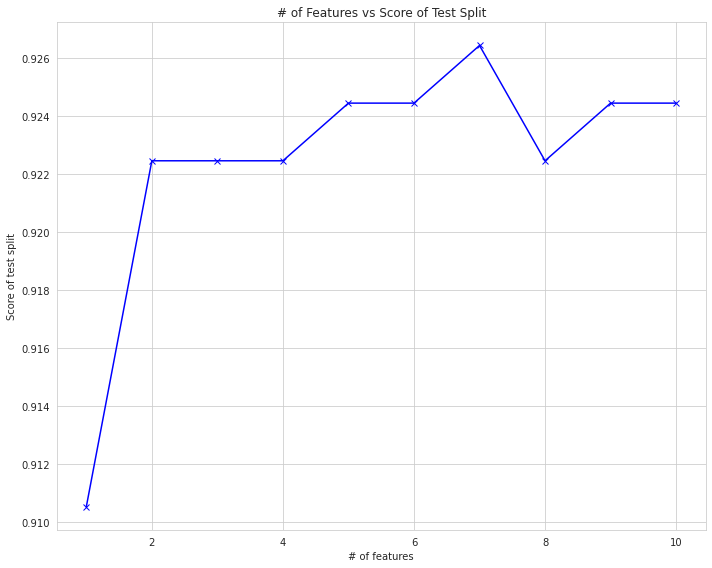

In [ ]:
feature_count = list(range(1,11))
score_list = []

for k in feature_count:
  SVM_model = SVC(probability=True, random_state= 1234)
  sfs4 = sfs(SVM_model,k_features=k, forward=True, scoring='roc_auc')
  sfs4.fit(X_train, y_train2)
  feat_names = list(sfs4.k_feature_names_)
  model = SVC(probability=True, random_state= 1234).fit(X_train[feat_names], y_train2)
  score = model.score(X_test[feat_names], y_test2) 
  score_list.append(score)

plt.figure(figsize=(10,8))
plt.plot(feature_count, score_list, 'bx-')
plt.xlabel('# of features')
plt.ylabel('Score of test split')
plt.title('# of Features vs Score of Test Split')
plt.show()

In [ ]:
SVM_model = SVC(probability=True, random_state= 1234)
sfs4 = sfs(SVM_model,k_features=7, forward=True, scoring='roc_auc')
sfs4.fit(X_train, y_train2)
feat_names_SVM = list(sfs4.k_feature_names_)
print(feat_names_SVM)

['S', 'K', 'tau', 'r', 'S/K', 'S-K_abs', 'tau_underroot']


In [ ]:
SVM_model = SVC(probability=True, random_state= 1234)
SVM_model.fit(X_train[feat_names_SVM], y_train2)
predictions_SVM = SVM_model.predict(X_test[feat_names_SVM])
print(confusion_matrix(y_test2,predictions_SVM))
print(classification_report(y_test2,predictions_SVM))

[[269  15]
 [ 22 197]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       284
           1       0.93      0.90      0.91       219

    accuracy                           0.93       503
   macro avg       0.93      0.92      0.92       503
weighted avg       0.93      0.93      0.93       503



### Hyperparameter Tuning

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],'kernel': ['rbf', 'poly', 'sigmoid','linear']}
grid_SVM = RandomizedSearchCV(SVC(probability = True, random_state = 1234),param_grid,cv=5, scoring = 'accuracy',random_state = 1234)
grid_SVM.fit(X_train[feat_names_SVM],y_train2)

RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=1234),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf', 'poly', 'sigmoid',
                                                   'linear']},
                   random_state=1234, scoring='accuracy')

In [ ]:
print(grid_SVM.best_params_)

{'kernel': 'linear', 'gamma': 0.01, 'C': 10}


In [ ]:
grid_predictions_SVM = grid_SVM.predict(X_test[feat_names_SVM])
print(confusion_matrix(y_test2,grid_predictions_SVM))
print(classification_report(y_test2,grid_predictions_SVM))

[[263  21]
 [ 16 203]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       284
           1       0.91      0.93      0.92       219

    accuracy                           0.93       503
   macro avg       0.92      0.93      0.93       503
weighted avg       0.93      0.93      0.93       503



## KNN Classifier

### Feature selection

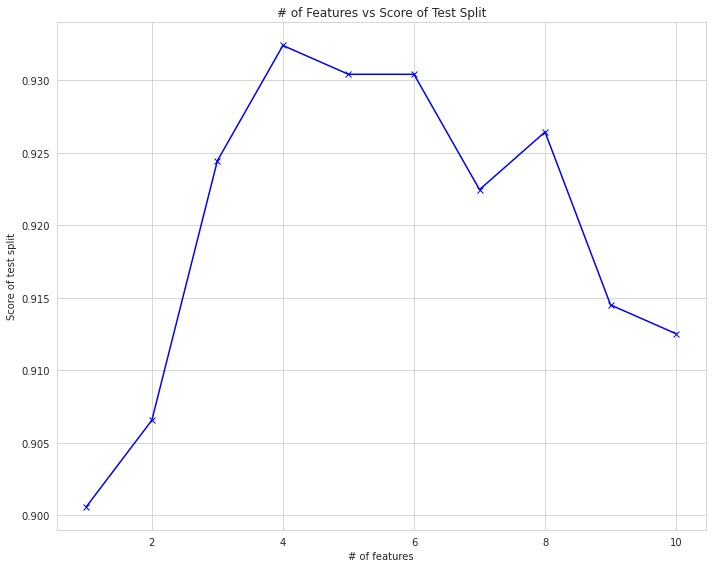

In [ ]:
feature_count = list(range(1,11))
score_list = []

for k in feature_count:
  knn_model = KNeighborsClassifier()
  sfs5 = sfs(knn_model,k_features=k, forward=True, scoring='roc_auc')
  sfs5.fit(X_train, y_train2)
  feat_names = list(sfs5.k_feature_names_)
  model = KNeighborsClassifier().fit(X_train[feat_names], y_train2)
  score = model.score(X_test[feat_names], y_test2) 
  score_list.append(score)

plt.figure(figsize=(10,8))
plt.plot(feature_count, score_list, 'bx-')
plt.xlabel('# of features')
plt.ylabel('Score of test split')
plt.title('# of Features vs Score of Test Split')
plt.show()

In [ ]:
knn_model = KNeighborsClassifier()
sfs5 = sfs(knn_model,k_features=4, forward=True, scoring='roc_auc')
sfs5.fit(X_train, y_train2)
feat_names_KNN = list(sfs5.k_feature_names_)
print(feat_names_KNN)

['S', 'S/K', 'tau_underroot', 'tau_power2']


In [ ]:
feat_names_KNN = feat_names_KNN + ['r']

In [ ]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train[feat_names_KNN], y_train2)
predictions_KNN = knn_model.predict(X_test[feat_names_KNN])
print(confusion_matrix(y_test2,predictions_KNN))
print(classification_report(y_test2,predictions_KNN))

[[267  17]
 [ 27 192]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       284
           1       0.92      0.88      0.90       219

    accuracy                           0.91       503
   macro avg       0.91      0.91      0.91       503
weighted avg       0.91      0.91      0.91       503



### Hyperparameter Tuning

In [ ]:
leaf_size = list(range(1,11))
n_neighbors = list(range(1,21))
p=[1,2]
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

grid_KNN = RandomizedSearchCV(KNeighborsClassifier(),hyperparameters,cv=5, scoring = 'roc_auc',random_state = 1234)
grid_KNN.fit(X_train[feat_names_KNN],y_train2)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19,
                                                        20],
                                        'p': [1, 2]},
                   random_state=1234, scoring='roc_auc')

In [ ]:
print(grid_KNN.best_params_)

{'p': 2, 'n_neighbors': 11, 'leaf_size': 5}


In [ ]:
grid_predictions_KNN = grid_KNN.predict(X_test[feat_names_KNN])
print(confusion_matrix(y_test2,grid_predictions_KNN))
print(classification_report(y_test2,grid_predictions_KNN))

[[264  20]
 [ 24 195]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       284
           1       0.91      0.89      0.90       219

    accuracy                           0.91       503
   macro avg       0.91      0.91      0.91       503
weighted avg       0.91      0.91      0.91       503



## Random Forest

### Feature selection

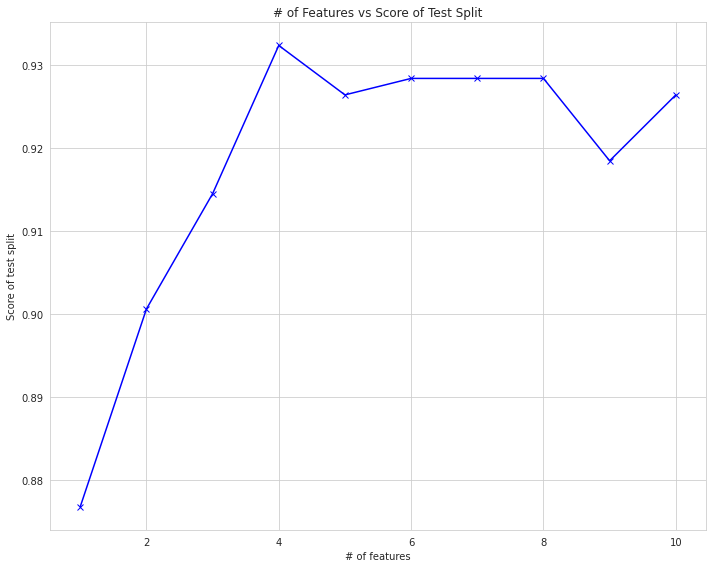

In [ ]:
feature_count = list(range(1,11))
score_list = []

for k in feature_count:
  rf = RandomForestClassifier(n_jobs=-1, random_state=1234)
  sfs6 = sfs(rf,k_features=k, forward=True, scoring='roc_auc')
  sfs6.fit(X_train, y_train2)
  feat_names = list(sfs6.k_feature_names_)
  model = RandomForestClassifier(n_jobs=-1, random_state=1234).fit(X_train[feat_names], y_train2)
  score = model.score(X_test[feat_names], y_test2) 
  score_list.append(score)

plt.figure(figsize=(10,8))
plt.plot(feature_count, score_list, 'bx-')
plt.xlabel('# of features')
plt.ylabel('Score of test split')
plt.title('# of Features vs Score of Test Split')
plt.show()

In [ ]:
rf = RandomForestClassifier(n_jobs=-1, random_state=1234)
sfs6 = sfs(rf,k_features=4, forward=True, scoring='roc_auc')
sfs6.fit(X_train, y_train2)
feat_names_RF = list(sfs6.k_feature_names_)
print(feat_names_RF)

['S', 'r', 'S/K', 'tau_underroot']


In [ ]:
# rf = RandomForestClassifier(n_jobs=-1, random_state=1234)
# rf.fit(X_train,y_train2)
# I = importances(rf, X_test, y_test2, random_state = 1234)
# plot_importances(I)
# feat_names_RF = list(I[I.Importance > 0].index)
# feat_names_RF

In [ ]:
rf = RandomForestClassifier(n_jobs=-1, random_state=1234)
rf.fit(X_train[feat_names_RF], y_train2)
predictions_RFC = rf.predict(X_test[feat_names_RF])
print(confusion_matrix(y_test2,predictions_RFC))
print(classification_report(y_test2,predictions_RFC))

[[265  19]
 [ 15 204]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       284
           1       0.91      0.93      0.92       219

    accuracy                           0.93       503
   macro avg       0.93      0.93      0.93       503
weighted avg       0.93      0.93      0.93       503



### Hyperparameter tuning

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 20)]
# max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
max_depth.append(None)
min_samples_split = [2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
              #  'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

grid_RF = RandomizedSearchCV(RandomForestClassifier(random_state = 1234),random_grid,cv=5, scoring = 'accuracy',random_state = 1234)
grid_RF.fit(X_train[feat_names_RF],y_train2)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, None],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [100, 105, 110, 115,
                                                         121, 126, 131, 136,
                                                         142, 147, 152, 157,
                                                         163, 168, 173, 178,
                                                         184, 189, 194, 200]},
                   random_state=1234, scoring='accuracy')

In [ ]:
print(grid_RF.best_params_)

{'n_estimators': 115, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 9, 'bootstrap': True}


In [ ]:
grid_predictions_RF = grid_RF.predict(X_test[feat_names_RF])
print(confusion_matrix(y_test2,grid_predictions_RF))
print(classification_report(y_test2,grid_predictions_RF))

[[266  18]
 [ 13 206]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       284
           1       0.92      0.94      0.93       219

    accuracy                           0.94       503
   macro avg       0.94      0.94      0.94       503
weighted avg       0.94      0.94      0.94       503



## Naive Bayes

### Feature selection

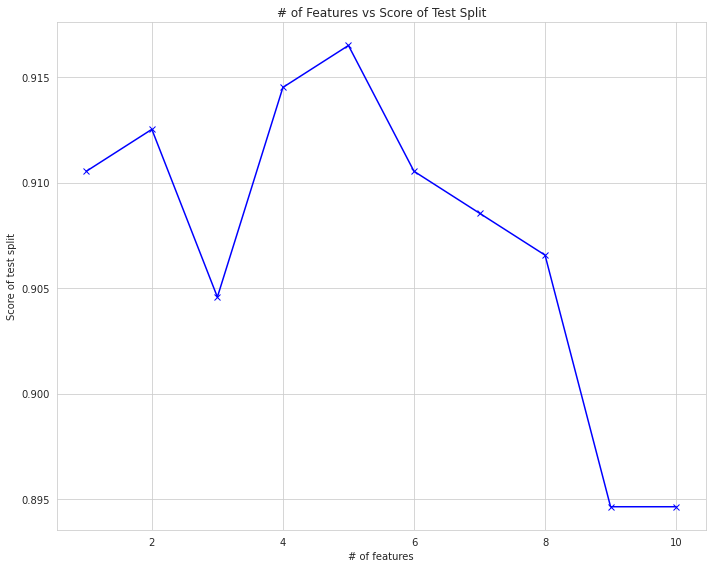

In [ ]:
feature_count = list(range(1,11))
score_list = []

for k in feature_count:
  nb_model = GaussianNB()
  sfs7 = sfs(nb_model,k_features=k, forward=True, scoring='roc_auc')
  sfs7.fit(X_train, y_train2)
  feat_names = list(sfs7.k_feature_names_)
  model = GaussianNB().fit(X_train[feat_names], y_train2)
  score = model.score(X_test[feat_names], y_test2) 
  score_list.append(score)

plt.figure(figsize=(10,8))
plt.plot(feature_count, score_list, 'bx-')
plt.xlabel('# of features')
plt.ylabel('Score of test split')
plt.title('# of Features vs Score of Test Split')
plt.show()

In [ ]:
nb_model = GaussianNB()
sfs7 = sfs(nb_model,k_features=5, forward=True, scoring='roc_auc')
sfs7.fit(X_train, y_train2)

feat_names_nb = list(sfs7.k_feature_names_)
print(feat_names_nb)

['S', 'r', 'S/K', 'S-K_abs', 'tau_power4']


In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train[feat_names_nb], y_train2)
predictions_NB = nb_model.predict(X_test[feat_names_nb])
print(confusion_matrix(y_test2,predictions_NB))
print(classification_report(y_test2,predictions_NB))

[[259  25]
 [ 17 202]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       284
           1       0.89      0.92      0.91       219

    accuracy                           0.92       503
   macro avg       0.91      0.92      0.92       503
weighted avg       0.92      0.92      0.92       503



## Model Selection

In [ ]:
classifiers_name = ['Logistic_reg', 'grid_SVM', 'grid_KNN', 'grid_RF','Naive_Bayes']
classifiers = [Logistic_reg, grid_SVM, grid_KNN, grid_RF, nb_model]
feature_list = [feat_names_LogR, feat_names_SVM, feat_names_KNN, feat_names_RF, feat_names_nb]
result_table = pd.DataFrame(columns=['model','classifiers', 'score', 'fpr' , 'tpr', 'auc'])

y_pred = pd.DataFrame(index = y_test2.index, columns = ['Logistic_reg', 'grid_SVM', 'grid_KNN', 'grid_RF','Naive_Bayes','final_prediction'])
threshold = []
for model_name, cls, feature in zip(classifiers_name,classifiers, feature_list):
  
  model = cls.fit(X_train[feature], y_train2)
  score = cls.score(X_test[feature], y_test2)
    
  model_prob = cls.predict_proba(X_test[feature])
  model_prob_ = model_prob[:,1]

  fpr,tpr, thresholds = roc_curve(y_test2, model_prob_)
  area = metrics.roc_auc_score(y_test2, model_prob_)

  preds = np.where(model_prob_ > 0.5, 1, 0)

  result_table = result_table.append({'model':model_name,
                                      'classifiers':cls.__class__.__name__,
                                      'score':score,
                                      'fpr':fpr, 
                                      'tpr':tpr, 
                                      'auc':area}, ignore_index=True)

  y_pred[model_name] = preds
    
# Set name of the classifiers as index labels
result_table.set_index('model', inplace=True)

In [ ]:
result_table

,classifiers,score,fpr,tpr,auc
model,,,,,
Logistic_reg,LogisticRegression,0.922465,"[0.0, 0.0035211267605633804, 0.007042253521126...","[0.0, 0.0, 0.0, 0.3013698630136986, 0.30136986...",0.974066
grid_SVM,RandomizedSearchCV,0.926441,"[0.0, 0.0035211267605633804, 0.007042253521126...","[0.0, 0.0, 0.0, 0.2831050228310502, 0.28310502...",0.974532
grid_KNN,RandomizedSearchCV,0.975288,"[0.0, 0.007042253521126761, 0.0070422535211267...","[0.0, 0.5296803652968036, 0.6529680365296804, ...",0.975288
grid_RF,RandomizedSearchCV,0.938370,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0045662100456621, 0.0410958904109589, ...",0.976719
Naive_Bayes,GaussianNB,0.916501,"[0.0, 0.0, 0.0, 0.007042253521126761, 0.007042...","[0.0, 0.0045662100456621, 0.0091324200913242, ...",0.971751


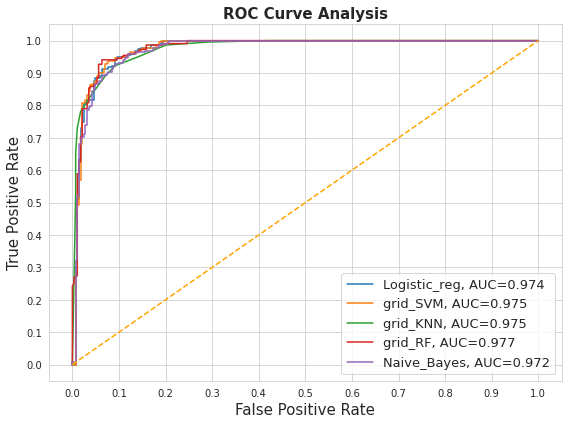

In [ ]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [ ]:
y_pred['final_prediction'] = 0
a = 0
for i in y_pred.index:
  for col in y_pred.columns:
    a += y_pred.loc[i,col]
  if a > 2:
    y_pred.loc[i,'final_prediction'] = 1
  a = 0

y_pred


,Logistic_reg,grid_SVM,grid_KNN,grid_RF,Naive_Bayes,final_prediction
1113,1,1,1,1,1,1
566,1,1,1,1,1,1
16,1,1,1,1,1,1
669,1,1,1,1,1,1
39,0,0,0,0,0,0
...,...,...,...,...,...,...
943,0,0,0,0,1,0
1473,0,0,0,0,0,0
167,1,1,0,1,1,1
1253,1,1,0,1,1,1


In [ ]:
print(confusion_matrix(y_test2, y_pred.final_prediction))

[[266  18]
 [ 17 202]]


# Final Prediction (Model training on 100% + result on w/o labels)

In [ ]:
data_withoutlabel = pd.read_csv('option_test_wolabel.csv')
data2 = data_withoutlabel.copy()

In [ ]:
data2["S/K"] = data2.S/data2.K #Currentassetvalue/Strikepriceofoption
data2["S-K_abs"] = abs(data2.S - data2.K) # abs(Currentassetvalue - Strikepriceofoption)
data2["tau_underroot"] = [math.sqrt(i) for i in data2.tau] #sqrt of Timetomaturity
data2["tau_power2"] = pow(data2.tau,2) # Timetomaturity in power 2
data2["tau_power4"] = pow(data2.tau,4) # Timetomaturity in power 4
data2["1+r"] = 1 + data2.r # 1 + Annualinterestrate

In [ ]:
data2 = pd.DataFrame(scaler.transform(data2), columns = data2.columns)

In [ ]:
# training model on 100% of the data
rf_reg_final = RandomForestRegressor(random_state=1234)
rf_reg_final.fit(X[feat_names_rfR], y1)
data2['Value'] = rf_reg_final.predict(data2[feat_names_rfR]) 

In [ ]:
classifiers_name = ['Logistic_reg', 'grid_SVM', 'grid_KNN', 'grid_RF','Naive_Bayes']
classifiers = [Logistic_reg, grid_SVM, grid_KNN, grid_RF, nb_model]
feature_list = [feat_names_LogR, feat_names_SVM, feat_names_KNN, feat_names_RF, feat_names_nb]

for model_name, cls, feature in zip(classifiers_name,classifiers, feature_list):

  # training model on 100% of the data
  model = cls.fit(X[feature], y2)
  model_prob = cls.predict_proba(data2[feature])
  model_prob_ = model_prob[:,1]
  preds = np.where(model_prob_ > 0.5, 1, 0)
  data2[model_name] = preds

In [ ]:
data2['BS'] = 0
a = 0
for i in data2.index:
  for col in ['Logistic_reg', 'grid_SVM', 'grid_KNN', 'grid_RF','Naive_Bayes']:
    a += data2.loc[i,col]
  if a > 2:
    data2.loc[i,'BS'] = 1
  a = 0

In [ ]:
final_data = data2[['Value','BS']]

In [ ]:
final_data.Value.describe()

count    1120.000000
mean       14.001607
std        13.890733
min         0.131300
25%         1.570751
50%         9.160602
75%        24.258199
max        59.044871
Name: Value, dtype: float64

In [ ]:
final_data.BS.sum()

557

In [ ]:
final_data.to_csv('group_11_prediction.csv', index= False)